<a href="https://colab.research.google.com/github/RevHeadGuy/Gold-Price-Prediction-/blob/main/Gold_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing the Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics

Data Collection and Processing

In [ ]:
# loading the csv data to a Pandas DataFrame
gold_data = pd.read_csv('/content/gld_price_data (1).csv')

Temporal Features

In [ ]:
# Convert the 'Date' column to datetime format for easier manipulation of date-based features
gold_data['Date'] = pd.to_datetime(gold_data['Date'])

# 1. Date-based Features
gold_data['Year'] = gold_data['Date'].dt.year
gold_data['Month'] = gold_data['Date'].dt.month
gold_data['DayOfWeek'] = gold_data['Date'].dt.dayofweek

# 2. Lagged Features (1-day and 7-day lag for GLD)
gold_data['GLD_Lag1'] = gold_data['GLD'].shift(1)
gold_data['GLD_Lag7'] = gold_data['GLD'].shift(7)

# 3. Rolling Mean and Volatility (7-day and 30-day rolling averages and standard deviations for GLD)
gold_data['GLD_RollingMean_7'] = gold_data['GLD'].rolling(window=7).mean()
gold_data['GLD_RollingMean_30'] = gold_data['GLD'].rolling(window=30).mean()
gold_data['GLD_RollingStd_7'] = gold_data['GLD'].rolling(window=7).std()
gold_data['GLD_RollingStd_30'] = gold_data['GLD'].rolling(window=30).std()



Price Change and Volatility

In [ ]:
# 1. Calculate Daily Price Change (%) for GLD
gold_data['GLD_Change'] = gold_data['GLD'].pct_change() * 100  # Percentage change for GLD

# 2. Calculate Rolling Volatility (Standard Deviation of Price Change)
gold_data['GLD_Volatility_7'] = gold_data['GLD_Change'].rolling(window=7).std()  # 7-day volatility
gold_data['GLD_Volatility_30'] = gold_data['GLD_Change'].rolling(window=30).std()  # 30-day volatility

# Repeat the same for other columns if needed (e.g., SPX, SLV)
# Example for SPX:
gold_data['SPX_Change'] = gold_data['SPX'].pct_change() * 100
gold_data['SPX_Volatility_7'] = gold_data['SPX_Change'].rolling(window=7).std()
gold_data['SPX_Volatility_30'] = gold_data['SPX_Change'].rolling(window=30).std()

In [ ]:
# Drop rows with NaN values that result from rolling and lag operations
gold_data = gold_data.dropna().reset_index(drop=True)


In [ ]:
# Save or preview the updated dataset
gold_data.to_csv('price_change_volatility_data.csv', index=False)  # Saves the new dataset to a CSV file
print(gold_data[['Date', 'GLD', 'GLD_Change', 'GLD_Volatility_7', 'GLD_Volatility_30']].head())  # Displays key columns

        Date        GLD  GLD_Change  GLD_Volatility_7  GLD_Volatility_30
0 2008-02-14  89.709999    0.301875          1.225585           1.263322
1 2008-02-15  89.150002   -0.624230          1.160088           1.265815
2 2008-02-19  91.580002    2.725743          1.523767           1.343511
3 2008-02-20  93.239998    1.812618          1.593571           1.366560
4 2008-02-21  93.250000    0.010727          1.598974           1.311656


In [ ]:
# print first 5 rows in the dataframe
gold_data.head()

,Date,SPX,GLD,USO,SLV,EUR/USD,Year,Month,DayOfWeek,GLD_Lag1,...,GLD_RollingMean_7,GLD_RollingMean_30,GLD_RollingStd_7,GLD_RollingStd_30,GLD_Change,GLD_Volatility_7,GLD_Volatility_30,SPX_Change,SPX_Volatility_7,SPX_Volatility_30
0,2008-02-14,1348.859985,89.709999,75.760002,17.087000,1.464408,2008,2,3,89.440002,...,89.944286,88.744000,0.886828,1.987964,0.301875,1.225585,1.263322,-1.342148,0.981534,1.479377
1,2008-02-15,1349.989990,89.150002,75.930000,16.952000,1.467610,2008,2,4,89.709999,...,89.972858,88.863333,0.851992,1.896197,-0.624230,1.160088,1.265815,0.083775,0.901558,1.479892
2,2008-02-19,1348.780029,91.580002,78.809998,17.378000,1.472993,2008,2,1,89.150002,...,90.220001,89.078333,1.040481,1.822532,2.725743,1.523767,1.343511,-0.089627,0.875681,1.418481
3,2008-02-20,1360.030029,93.239998,79.320000,17.700001,1.472299,2008,2,2,91.580002,...,90.540001,89.360667,1.543307,1.787827,1.812618,1.593571,1.366560,0.834087,0.872718,1.427306
4,2008-02-21,1342.530029,93.250000,77.330002,17.695999,1.481503,2008,2,3,93.239998,...,90.814286,89.576333,1.847708,1.854771,0.010727,1.598974,1.311656,-1.286736,1.043610,1.408025


In [ ]:
# print last 5 rows of the dataframe
gold_data.tail()

,Date,SPX,GLD,USO,SLV,EUR/USD,Year,Month,DayOfWeek,GLD_Lag1,...,GLD_RollingMean_7,GLD_RollingMean_30,GLD_RollingStd_7,GLD_RollingStd_30,GLD_Change,GLD_Volatility_7,GLD_Volatility_30,SPX_Change,SPX_Volatility_7,SPX_Volatility_30
2255,2018-05-08,2671.919922,124.589996,14.0600,15.5100,1.186789,2018,5,1,124.570000,...,124.337142,126.153334,0.491823,1.367692,0.016052,0.402197,0.772655,-0.026564,0.881722,1.285154
2256,2018-05-09,2697.790039,124.330002,14.3700,15.5300,1.184722,2018,5,2,124.589996,...,124.245713,126.154001,0.406687,1.366767,-0.208680,0.390422,0.769137,0.968222,0.869804,1.298012
2257,2018-05-10,2723.070068,125.180000,14.4100,15.7400,1.191753,2018,5,3,124.330002,...,124.330000,126.110667,0.531820,1.376647,0.683663,0.464343,0.708212,0.937064,0.814174,1.309079
2258,2018-05-14,2730.129883,124.489998,14.3800,15.5600,1.193118,2018,5,0,125.180000,...,124.441428,126.061000,0.456669,1.408044,-0.551208,0.423078,0.711533,0.259259,0.814044,1.218446
2259,2018-05-16,2725.780029,122.543800,14.4058,15.4542,1.182033,2018,5,2,124.489998,...,124.283399,125.892127,0.821696,1.515561,-1.563337,0.759638,0.718412,-0.159328,0.705265,1.146423


In [ ]:
# number of rows and columns
gold_data.shape

(2260, 21)

In [ ]:
# getting some basic informations about the data
gold_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260 entries, 0 to 2259
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                2260 non-null   datetime64[ns]
 1   SPX                 2260 non-null   float64       
 2   GLD                 2260 non-null   float64       
 3   USO                 2260 non-null   float64       
 4   SLV                 2260 non-null   float64       
 5   EUR/USD             2260 non-null   float64       
 6   Year                2260 non-null   int32         
 7   Month               2260 non-null   int32         
 8   DayOfWeek           2260 non-null   int32         
 9   GLD_Lag1            2260 non-null   float64       
 10  GLD_Lag7            2260 non-null   float64       
 11  GLD_RollingMean_7   2260 non-null   float64       
 12  GLD_RollingMean_30  2260 non-null   float64       
 13  GLD_RollingStd_7    2260 non-null   float64     

In [ ]:
# checking the number of missing values
gold_data.isnull().sum()

,0
Date,0
SPX,0
GLD,0
USO,0
SLV,0
EUR/USD,0
Year,0
Month,0
DayOfWeek,0
GLD_Lag1,0


In [ ]:
# getting the statistical measures of the data
gold_data.describe()

,Date,SPX,GLD,USO,SLV,EUR/USD,Year,Month,DayOfWeek,GLD_Lag1,...,GLD_RollingMean_7,GLD_RollingMean_30,GLD_RollingStd_7,GLD_RollingStd_30,GLD_Change,GLD_Volatility_7,GLD_Volatility_30,SPX_Change,SPX_Volatility_7,SPX_Volatility_30
count,2260,2260.000000,2260.000000,2260.000000,2260.000000,2260.000000,2260.000000,2260.000000,2260.000000,2260.000000,...,2260.000000,2260.000000,2260.000000,2260.000000,2260.000000,2260.000000,2260.000000,2260.000000,2260.000000,2260.000000
mean,2013-04-11 07:25:22.831858432,1658.082459,123.186201,31.296264,20.136850,1.281096,2012.787611,6.396018,1.763717,123.171553,...,123.141010,122.956841,1.459155,2.921583,0.022327,1.111430,1.173485,0.039765,1.067669,1.119554
min,2008-02-14 00:00:00,676.530029,70.000000,7.960000,8.850000,1.039047,2008.000000,1.000000,0.000000,70.000000,...,72.131431,74.267667,0.242408,0.620663,-13.068523,0.199527,0.455972,-9.034978,0.106707,0.250293
25%,2010-09-29 18:00:00,1234.012482,110.489998,14.057500,15.560000,1.164629,2010.000000,3.000000,1.000000,110.484999,...,110.243927,109.726416,0.890453,1.863113,-0.569577,0.686152,0.804931,-0.398622,0.521641,0.643805
50%,2013-04-06 00:00:00,1562.959961,120.730003,33.764999,17.330000,1.301330,2013.000000,6.000000,2.000000,120.725002,...,120.672857,119.920167,1.224911,2.542068,0.047950,0.958650,1.018998,0.075808,0.820275,0.888442
75%,2015-11-04 06:00:00,2076.127564,133.167499,37.682500,23.205000,1.367633,2015.000000,10.000000,3.000000,133.167499,...,133.528930,132.981667,1.762991,3.490395,0.633858,1.317769,1.356718,0.594488,1.272322,1.275080
max,2018-05-16 00:00:00,2872.870117,184.589996,117.480003,47.259998,1.598798,2018.000000,12.000000,4.000000,184.589996,...,179.021428,173.925333,10.467907,10.290857,11.290530,5.877849,4.148368,10.789006,6.946101,5.391614
std,NaN,521.491707,23.098986,19.062723,7.124768,0.130490,2.962810,3.567137,1.275614,23.109887,...,23.074223,23.024460,0.951321,1.573979,1.293300,0.670993,0.564483,1.356527,0.888217,0.786283


Correlation:
1. Positive Correlation
2. Negative Correlation

In [ ]:

# Calculate the correlation matrix
correlation = gold_data.corr()

<Axes: >

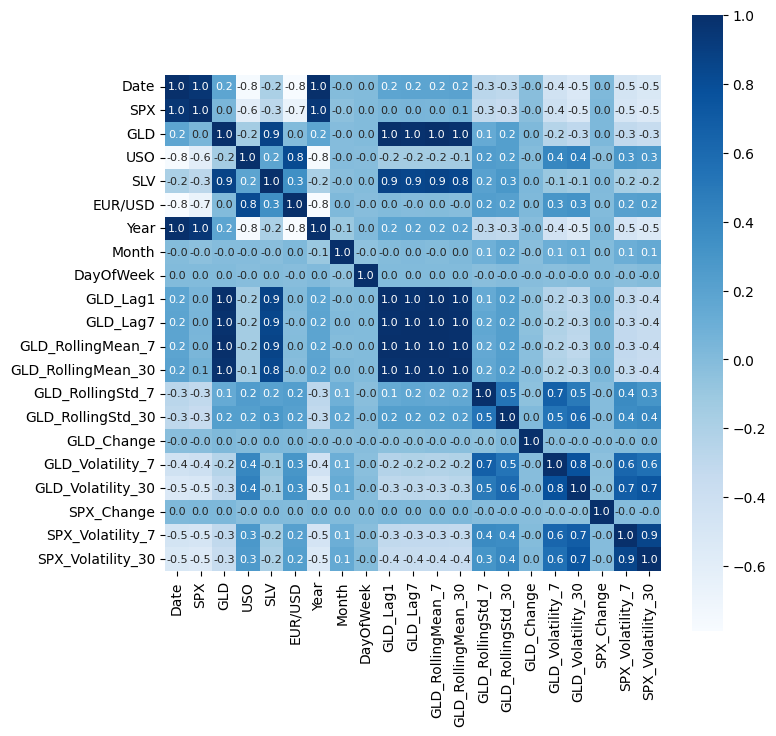

In [ ]:
# constructing a heatmap to understand the correlatiom
plt.figure(figsize = (8,8))
sns.heatmap(correlation, cbar=True, square=True, fmt='.1f',annot=True, annot_kws={'size':8}, cmap='Blues')

In [ ]:
# correlation values of GLD
print(correlation['GLD'])

Date                  0.181729
SPX                   0.039387
GLD                   1.000000
USO                  -0.151952
SLV                   0.870152
EUR/USD               0.004248
Year                  0.181513
Month                -0.007023
DayOfWeek             0.003499
GLD_Lag1              0.997767
GLD_Lag7              0.985309
GLD_RollingMean_7     0.996088
GLD_RollingMean_30    0.982008
GLD_RollingStd_7      0.135020
GLD_RollingStd_30     0.229274
GLD_Change            0.021674
GLD_Volatility_7     -0.243775
GLD_Volatility_30    -0.299436
SPX_Change            0.024231
SPX_Volatility_7     -0.311755
SPX_Volatility_30    -0.349958
Name: GLD, dtype: float64


<ipython-input-16-b94eac2e88dd>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(gold_data['GLD'],color='green')


<Axes: xlabel='GLD', ylabel='Density'>

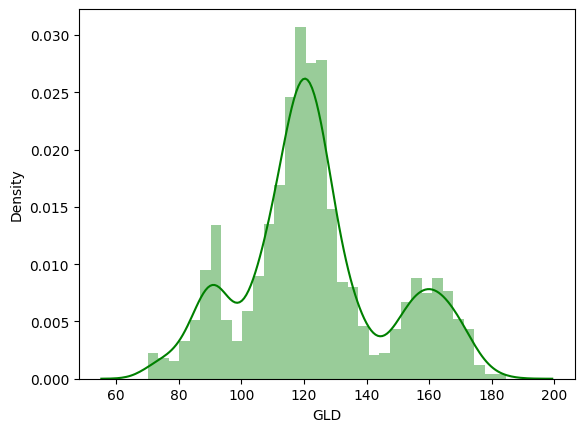

In [ ]:
# checking the distribution of the GLD Price
sns.distplot(gold_data['GLD'],color='green')

Splitting the Features and Target

In [ ]:
X = gold_data.drop(['Date','GLD'],axis=1)
Y = gold_data['GLD']

In [ ]:
print(X)

              SPX        USO        SLV   EUR/USD  Year  Month  DayOfWeek  \
0     1348.859985  75.760002  17.087000  1.464408  2008      2          3   
1     1349.989990  75.930000  16.952000  1.467610  2008      2          4   
2     1348.780029  78.809998  17.378000  1.472993  2008      2          1   
3     1360.030029  79.320000  17.700001  1.472299  2008      2          2   
4     1342.530029  77.330002  17.695999  1.481503  2008      2          3   
...           ...        ...        ...       ...   ...    ...        ...   
2255  2671.919922  14.060000  15.510000  1.186789  2018      5          1   
2256  2697.790039  14.370000  15.530000  1.184722  2018      5          2   
2257  2723.070068  14.410000  15.740000  1.191753  2018      5          3   
2258  2730.129883  14.380000  15.560000  1.193118  2018      5          0   
2259  2725.780029  14.405800  15.454200  1.182033  2018      5          2   

        GLD_Lag1    GLD_Lag7  GLD_RollingMean_7  GLD_RollingMean_30  \
0   

In [ ]:
print(Y)

0        89.709999
1        89.150002
2        91.580002
3        93.239998
4        93.250000
           ...    
2255    124.589996
2256    124.330002
2257    125.180000
2258    124.489998
2259    122.543800
Name: GLD, Length: 2260, dtype: float64


Splitting into Training data and Test Data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=2)

Build the Linear Regression Model

In [ ]:
# Create and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict the test set results
y_pred = model.predict(X_test)


Model Training: Linear Regressor


In [ ]:
# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R-squared: {r2}')


MSE: 0.22010503907034965
RMSE: 0.46915353464548215
R-squared: 0.9995941327861543


Model Training:Random Forest Regressor

In [ ]:
regressor = RandomForestRegressor(n_estimators=100)

Model Evaluation

In [ ]:
# training the model
regressor.fit(X_train,y_train)

RandomForestRegressor()

In [ ]:
# prediction on Test Data
test_data_prediction = regressor.predict(X_test)

In [ ]:
print(test_data_prediction)

[123.99319999  72.58300059  90.03780005 125.63979952 170.38049967
  87.80129914 121.64170007 116.58069948 153.22029802 156.18000053
  87.29919882 106.79740068 168.78150158 160.09830296  91.58910005
 121.43650122 106.74750072 113.34250036 150.73150015 118.69850148
 141.29860252 108.36670062 177.34559576 146.61950074  85.32059919
 121.32440005 115.24640129 104.84819992 135.2395021  117.29110083
 109.4495998  152.69329955 132.99039866 126.00860021 162.38620026
 172.84200214 124.07739978  82.0535006   73.62550073 165.29409991
 156.19210089 122.60699941 159.59919714 111.93990029 158.52139966
 139.02419778 115.66500008 103.0937995   86.19359808 169.01429987
 167.53389951 119.65040001 107.7483991   87.62949876 130.99310052
 109.0822991  121.48529965 127.63099998 113.98559975 157.44510054
 102.36309906 154.07899996 109.72249967 105.2580998  122.62979888
 127.67560005 161.58490084 122.59839952 152.82429895  85.51339846
 121.95727489 128.92589933 104.92500052 152.00820029 114.1002988
 147.899799

In [ ]:
# R squared error
error_score = metrics.r2_score(y_test, test_data_prediction)
print("R squared error : ", error_score)

R squared error :  0.9967506095102615


Compare the Actual Values and Predicted Values in a Plot

In [ ]:
y_test = list(y_test)

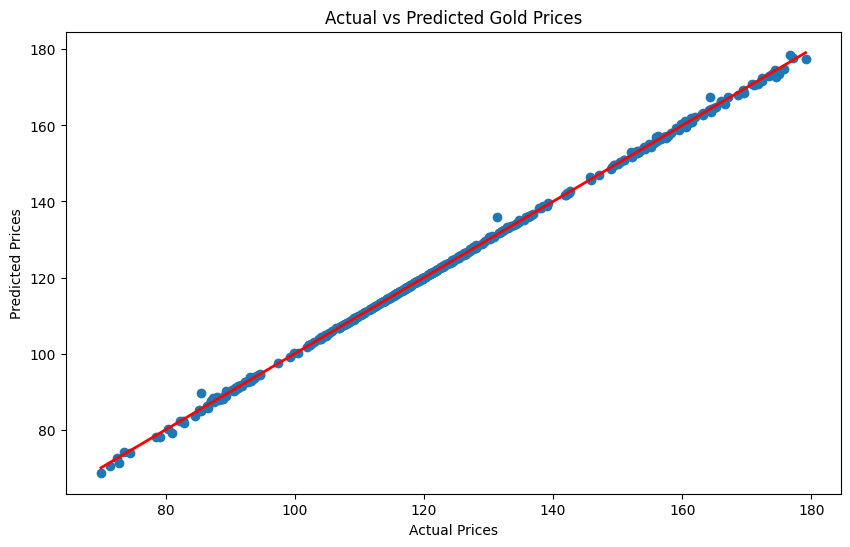

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Gold Prices')
plt.show()
